In [1]:
import wandb
from transformers import TrainingArguments, Trainer

wandb.init(project="my-test-project", entity="johnnydevriese")

wandb: Currently logged in as: johnnydevriese (use `wandb login --relogin` to force relogin)


In [2]:
# i guess this is all you really need for wandb

# args = TrainingArguments(..., report_to="wandb")

# trainer = Trainer(..., args=args)
# trainer.train()

In [3]:
from huggingface_hub import notebook_login

notebook_login()


In [4]:
from datasets import load_dataset

dataset = load_dataset('beans')
dataset

Using custom data configuration default
Reusing dataset beans (/Users/johnnydevriese/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)
100%|██████████| 3/3 [00:00<00:00, 834.96it/s]


DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

### Let's take a look at some of our data

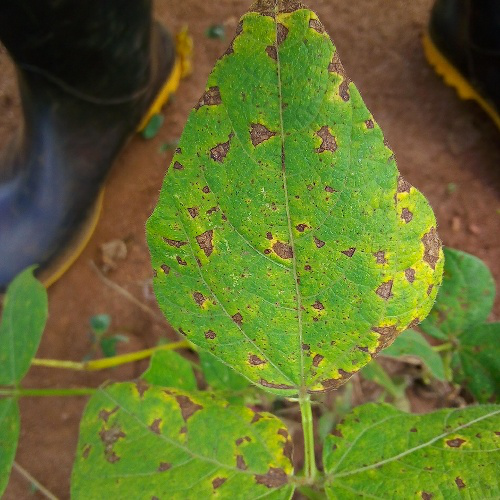

In [5]:
ex = dataset['train'][400]
ex['image']

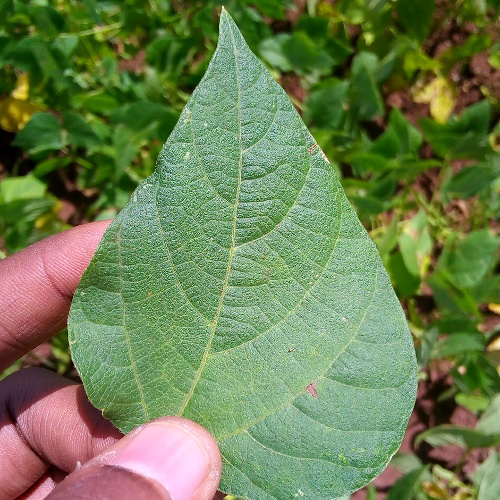

In [27]:
ex2 = dataset['train'][22]
ex2['image']

In [6]:
labels = dataset['train'].features['labels']
labels

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [7]:
print(ex['labels'])
print(ex2['labels'])

labels.int2str(ex['labels'])


0


NameError: name 'ex2' is not defined

Loading cached processed dataset at /Users/johnnydevriese/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791/cache-e56132f7dc287226.arrow
Loading cached processed dataset at /Users/johnnydevriese/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791/cache-e7d1763eb2fb45e7.arrow
Loading cached processed dataset at /Users/johnnydevriese/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791/cache-9f61c87a366d1635.arrow


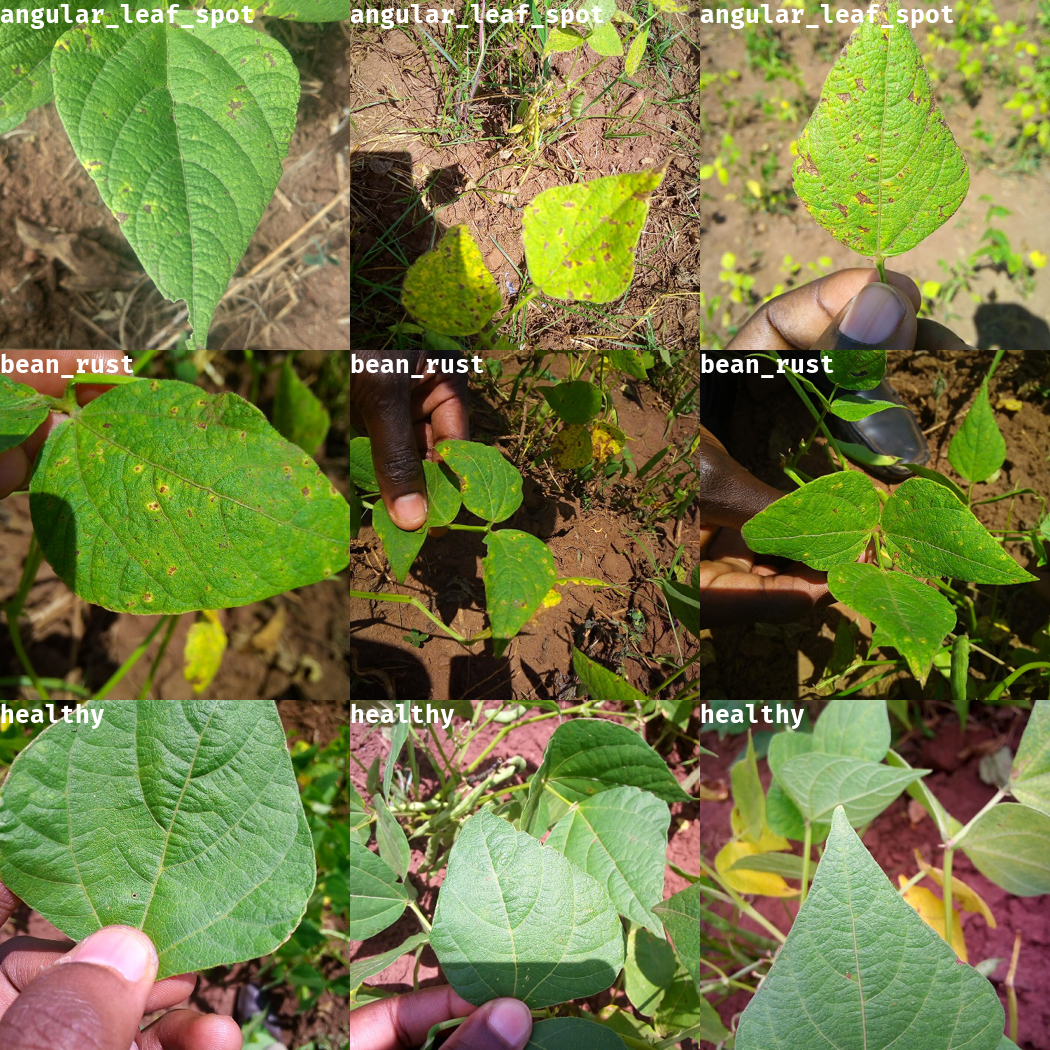

In [8]:
import random
from PIL import ImageDraw, ImageFont, Image

MACOS_FONT = "~/Library/Fonts/FiraCode-Bold.ttf"

def show_examples(dataset, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = dataset['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    # presumably where fonts are stored on a linux box. 
    # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)
    font = ImageFont.truetype(MACOS_FONT, size=24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = dataset['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=3)

### Let's Load up a pretrained ViT model from HuggingFace

In [9]:
from transformers import ViTFeatureExtractor

model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

In [10]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [11]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [12]:
prepared_ds = dataset.with_transform(transform)

In [13]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.4510, -0.4745, -0.4902,  ...,  0.4824,  0.4745,  0.3490],
          [-0.4118, -0.4510, -0.4667,  ...,  0.3176,  0.3333,  0.2863],
          [-0.2784, -0.2941, -0.3020,  ...,  0.1843,  0.2392,  0.2314],
          ...,
          [ 0.6706,  0.6706,  0.6706,  ...,  0.1451,  0.0980,  0.0353],
          [ 0.6627,  0.6627,  0.6627,  ...,  0.1451,  0.1059,  0.0510],
          [ 0.6078,  0.6471,  0.6549,  ...,  0.1294,  0.1137, -0.0039]],

         [[-0.6627, -0.6941, -0.7020,  ...,  0.1765,  0.1686,  0.0353],
          [-0.4745, -0.5765, -0.6549,  ...,  0.0039,  0.0196, -0.0275],
          [-0.1922, -0.2706, -0.3412,  ..., -0.1529, -0.0902, -0.1059],
          ...,
          [ 0.1843,  0.1843,  0.1686,  ..., -0.0431,  0.0039, -0.0275],
          [ 0.1608,  0.1686,  0.1608,  ..., -0.1294, -0.1137, -0.0980],
          [ 0.0980,  0.1373,  0.1608,  ..., -0.1529, -0.1451, -0.1765]],

         [[-0.8588, -0.8588, -0.8588,  ...,  0.0588,  0.0824, -0.0431],
          [-0

In [14]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [15]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [17]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./hugging_face/vit_beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1, # was initially set to 4 but I want to try to push to HF hub
#   fp16=True, # can only use fp16 on gpu or something? 
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  # push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
  push_to_hub=True # this is important! 
)

PyTorch: setting up devices


In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

Cloning https://huggingface.co/johnnydevriese/vit_beans into local empty directory.


In [23]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 1034
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 65
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
  0%|          | 0/65 [00:00<?, ?it/s]/Users/johnnydevriese/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/transformers/modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(
 15%|█▌        | 10/65 [00:39<03:33,  3.88s/it]

{'loss': 0.801, 'learning_rate': 0.00016923076923076923, 'epoch': 0.15}


 31%|███       | 20/65 [01:17<02:50,  3.79s/it]

{'loss': 0.4026, 'learning_rate': 0.00013846153846153847, 'epoch': 0.31}


 46%|████▌     | 30/65 [01:54<02:10,  3.73s/it]

{'loss': 0.309, 'learning_rate': 0.0001076923076923077, 'epoch': 0.46}


 62%|██████▏   | 40/65 [02:32<01:32,  3.69s/it]

{'loss': 0.3093, 'learning_rate': 7.692307692307693e-05, 'epoch': 0.62}


 77%|███████▋  | 50/65 [03:08<00:55,  3.73s/it]

{'loss': 0.2294, 'learning_rate': 4.615384615384616e-05, 'epoch': 0.77}


 92%|█████████▏| 60/65 [03:44<00:18,  3.69s/it]

{'loss': 0.1809, 'learning_rate': 1.5384615384615387e-05, 'epoch': 0.92}


100%|██████████| 65/65 [04:02<00:00,  3.46s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 65/65 [04:02<00:00,  3.74s/it]
Saving model checkpoint to ./hugging_face/vit_beans
Configuration saved in ./hugging_face/vit_beans/config.json
Model weights saved in ./hugging_face/vit_beans/pytorch_model.bin
Configuration saved in ./hugging_face/vit_beans/preprocessor_config.json


{'train_runtime': 242.8167, 'train_samples_per_second': 4.258, 'train_steps_per_second': 0.268, 'train_loss': 0.35707517037024866, 'epoch': 1.0}
***** train metrics *****
  epoch                    =        1.0
  train_loss               =     0.3571
  train_runtime            = 0:04:02.81
  train_samples_per_second =      4.258
  train_steps_per_second   =      0.268


In [24]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
100%|██████████| 17/17 [00:10<00:00,  1.57it/s]

***** eval metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.9699
  eval_loss               =     0.1176
  eval_runtime            = 0:00:11.44
  eval_samples_per_second =     11.625
  eval_steps_per_second   =      1.486


In [25]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

trainer.push_to_hub("my-vit-model")

# if training_args.push_to_hub:
#     trainer.push_to_hub('🍻 cheers', **kwargs)
# else:
#     trainer.create_model_card(**kwargs)

Saving model checkpoint to ./hugging_face/vit_beans
Configuration saved in ./hugging_face/vit_beans/config.json
Model weights saved in ./hugging_face/vit_beans/pytorch_model.bin
Configuration saved in ./hugging_face/vit_beans/preprocessor_config.json
Upload file pytorch_model.bin: 100%|█████████▉| 326M/327M [03:24<00:00, 1.68MB/s] To https://huggingface.co/johnnydevriese/vit_beans
   dccd5ad..25d3f23  main -> main

Upload file pytorch_model.bin: 100%|██████████| 327M/327M [03:26<00:00, 1.67MB/s]
Upload file training_args.bin: 100%|██████████| 2.86k/2.86k [03:26<?, ?B/s]
To https://huggingface.co/johnnydevriese/vit_beans
   25d3f23..3121791  main -> main



'https://huggingface.co/johnnydevriese/vit_beans/commit/25d3f23466c4964c32e1ac416ba1712fedcce6c1'